# Anomaly Detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from hdbscan import HDBSCAN

เราสามารถระบุว่า data point หนึ่งเป็น anomaly (ซึ่งอาจเป็นข้อมูลที่มีประโยชน์หรือเป็น outlier ก็ได้) ได้หลายวิธี

## One-Class SVM (OCSVM)

One-Class SVM (OCSVM) เป็น SVM ที่ใช้ในการระบุ anomaly มีหลักการคือ หา hyperplane ที่ตัดผ่าน centre of mass ของ data point เช่น ถ้าข้อมูลถูก standardised (ทำให้ข้อมูลมี mean เป็น 0 กับ variance เป็น 1) hyperplane จะตัดผ่าน origin

Hyperparameter ที่สำคัญ เช่น
- `nu` คือ สัดส่วนของ anomaly ที่มีใน dataset เราต้องกำหนดเองว่าอยากให้มี anomaly มากแค่ไหน (`nu=0.5` by default)
- `kernel` กำหนดเหมือนตอนทำ SVM (`kernel=rbf` by default)

เราสามารถสร้าง OCSVM model ได้โดยใช้ `sklearn.svm.OneClassSVM` และระบุแต่ละ data point ว่าเป็น outlier หรือไม่โดยใช้ `.predict` method (ถ้าเป็น outlier จะได้ -1 แต่ถ้าเป็น inlier จะได้ 1)

In [2]:
# Import data and drop duplicates
data = pd.read_csv('../data/penguins.csv').drop_duplicates()
# Features (X) and target (y)
X = data.drop(columns="species")
y = data["species"]
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
# Encode the target
label_encoder = LabelEncoder().fit(y_train)
y_train = pd.Series(data=label_encoder.transform(y_train), name="species")
y_test = pd.Series(data=label_encoder.transform(y_test), name="species")

In [3]:
# Prepare new X_train to have outliers
neg_out = pd.DataFrame(data=[X_train.min()*2], columns=X_train.columns)
pos_out = pd.DataFrame(data=[X_train.max()*2], columns=X_train.columns)
X_train_new = pd.concat([X_train, neg_out, pos_out], ignore_index=True)
X_train_new

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-0.541701,0.567256,-0.647443,-0.191722
1,0.431834,0.365582,-0.719893,-0.636575
2,1.093102,-0.894882,1.381175,1.714789
3,-1.129496,0.768930,-2.096455,-1.335629
4,-0.468227,0.718511,0.004613,-0.255273
...,...,...,...,...
257,0.799205,-0.390696,1.381175,1.524138
258,1.184945,-0.592371,1.743428,1.524138
259,1.184945,1.273115,0.004613,-0.191722
260,-4.389746,-4.008180,-4.192911,-3.815165


In [4]:
# Create an OCSVM model and fit on the new training set
ocsvm = OneClassSVM(nu=0.05).fit(X_train_new)

In [5]:
# Predict labels for the new training set (outlier = -1, inlier = 1)
outlier_predictions = ocsvm.predict(X_train_new)
outlier_predictions

array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

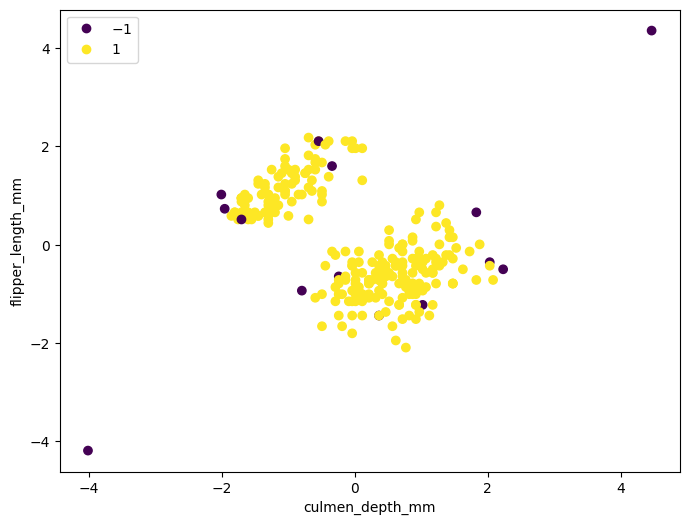

In [6]:
# Plot outliers and inliers
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_train_new["culmen_depth_mm"],
    X_train_new["flipper_length_mm"],
    c=outlier_predictions,
)
ax.set(xlabel="culmen_depth_mm", ylabel="flipper_length_mm")
ax.legend(*scatter.legend_elements());

## Isolation Forest (IFOR)

ประยุกต์จาก Random Forest classifier โดยมีหลักการคือ ถ้า data point อยู่ใน leaf node ที่อยู่ใกล้ root node แสดงว่าข้อมูลเหล่านั้นต่างจากข้อมูลอื่น ๆ จึงมีโอกาสเป็น outlier มาก

<img src="../images/isolation_forest.png" width="600" /><br />

Hyperparameter ที่สำคัญ เช่น
- `contamination` คือ สัดส่วนของ anomaly ที่มีใน dataset เราต้องกำหนดเองว่าอยากให้มี anomaly มากแค่ไหน (`contamination="auto"` (0.1) by default)
- `n_estimators` จำนวน base estimator ใน ensemble (`n_estimators=100` by default)

เราสามารถสร้าง IFOR model ได้โดยใช้ `sklearn.ensemble.IsolationForest` และระบุแต่ละ data point ว่าเป็น outlier หรือไม่โดยใช้ `.predict` method (ถ้าเป็น outlier จะได้ -1 แต่ถ้าเป็น inlier จะได้ 1)

In [7]:
# Create an IFOR model and fit on the new training set
ifor = IsolationForest(contamination=0.05, random_state=5).fit(X_train_new)

In [8]:
# Predict labels for the new training set (outlier = -1, inlier = 1)
outlier_predictions = ifor.predict(X_train_new)
outlier_predictions

array([ 1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1, -1

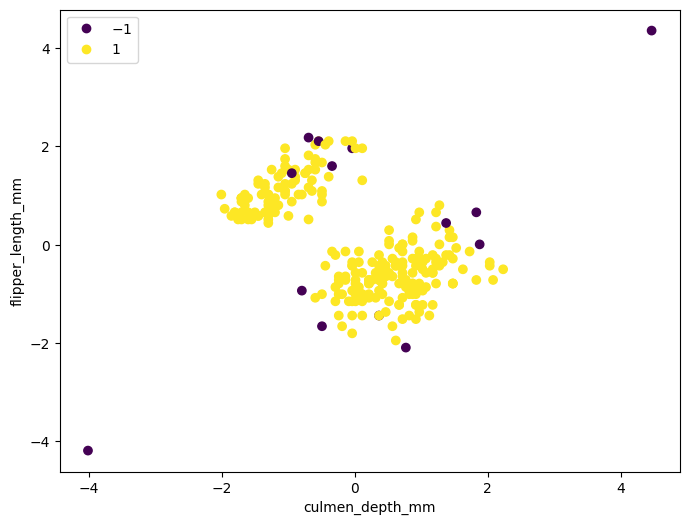

In [9]:
# Plot outliers and inliers
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_train_new["culmen_depth_mm"],
    X_train_new["flipper_length_mm"],
    c=outlier_predictions,
)
ax.set(xlabel="culmen_depth_mm", ylabel="flipper_length_mm")
ax.legend(*scatter.legend_elements());

## HDBSCAN

หลักการคือ แปลงระยะห่างของ data point หนึ่งจาก region ที่มี data point หนาแน่นเป็น outlier score 

data point ที่มี outlier score สูงจะเป็น outlier

เราสามารถสร้าง HDBSCAN model ได้โดยใช้ `hdbscan.HDBSCAN` และดูค่า outlier score ของแต่ละ data point ได้โดยใช้ `.outlier_scores_`

In [10]:
# Create an HDBSCAN model and fit on the new training set
hdbscan = HDBSCAN().fit(X_train_new)

In [11]:
# Predict labels for the new training set (outlier = -1, inlier = 1)
outlier_predictions = hdbscan.outlier_scores_
outlier_predictions

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.17528981e-01,
       2.02134248e-01, 3.31070375e-02, 8.89695744e-02, 5.25413368e-02,
       0.00000000e+00, 1.83951358e-01, 2.76037468e-02, 1.06928111e-01,
       2.85289298e-02, 1.00640982e-02, 1.00267331e-01, 9.57614105e-02,
       3.34814633e-02, 3.25418513e-03, 1.81681168e-01, 3.01732971e-01,
       1.84894562e-01, 5.25413368e-02, 2.92216091e-01, 5.10829503e-02,
       6.24714120e-02, 1.21481994e-02, 1.83110823e-01, 1.92506290e-01,
       1.30760317e-01, 9.85428190e-02, 9.84947626e-02, 5.15652155e-01,
       0.00000000e+00, 6.70578141e-02, 2.61764707e-01, 1.06975492e-01,
       2.34609784e-01, 1.25192260e-01, 1.05076823e-01, 1.69992303e-01,
       1.11601002e-02, 4.73255408e-02, 5.03589579e-03, 3.17939167e-01,
       3.00210429e-01, 2.04815495e-01, 1.52876096e-01, 2.09967784e-01,
       8.29642612e-02, 4.92036372e-04, 1.16419251e-01, 1.93662811e-01,
       0.00000000e+00, 3.87094596e-02, 4.28315840e-02, 5.25413368e-02,
      

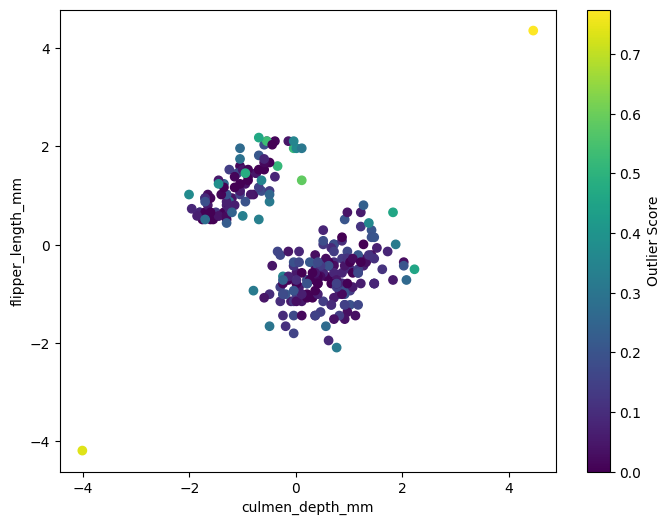

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_train_new["culmen_depth_mm"],
    X_train_new["flipper_length_mm"],
    c=outlier_predictions,
)
ax.set(xlabel="culmen_depth_mm", ylabel="flipper_length_mm")
plt.colorbar(scatter, label='Outlier Score');